In [2]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Carregamento e Processamento dos Dados

In [4]:
data_2015 = pd.read_csv('dataset/acidentes-transito-2015.csv')
data_2016 = pd.read_csv('dataset/acidentes_2016.csv')
data_2017 = pd.read_csv('dataset/acidentes_2017.csv')
data_2018 = pd.read_csv('dataset/acidentes_2018.csv')
data_2019 = pd.read_csv('dataset/acidentes-2019.csv')

In [70]:
data_2015.data.min()

Timestamp('2015-06-01 00:00:00')

In [5]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12062 entries, 0 to 12061
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       12062 non-null  object 
 1   hora                       12046 non-null  object 
 2   natureza_acidente          12058 non-null  object 
 3   situacao                   12058 non-null  object 
 4   bairro                     11914 non-null  object 
 5   endereco                   12009 non-null  object 
 6   numero                     6004 non-null   object 
 7   detalhe_endereco_acidente  4311 non-null   object 
 8   complemento                9600 non-null   object 
 9   endereco_cruzamento        11991 non-null  object 
 10  numero_cruzamento          6223 non-null   object 
 11  referencia_cruzamento      9407 non-null   object 
 12  bairro_cruzamento          11888 non-null  object 
 13  num_semaforo               3346 non-null   obj

### Agrupamento dos dados para análise

In [6]:
df_list = [data_2015, data_2016, data_2017, data_2018, data_2019]
df_new_list = []

In [7]:
for i in df_list:
    i['data'] = pd.to_datetime(i.data)
    df_new = i.resample(rule='1D', on='data').agg({'data': 'count'})
    df_new = df_new.rename(columns={'data':'count'})    
    df_new_list.append(df_new)

In [8]:
full_df = pd.concat(df_new_list)

### Visualização da Série Temporal com sua respectiva média móvel e desvio padrão

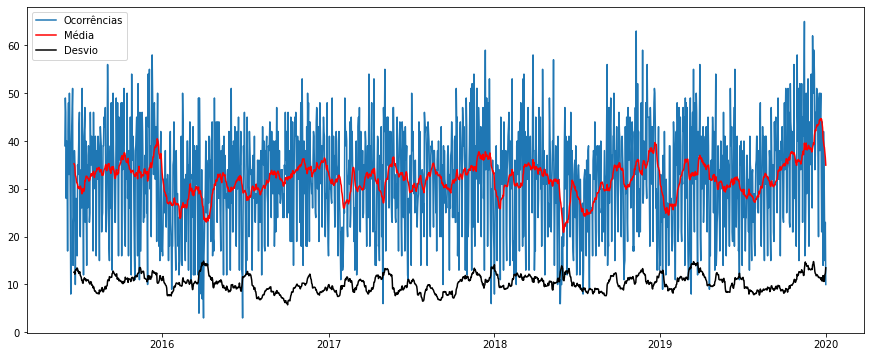

In [67]:
m_m1 = full_df.rolling(window=21).mean()
m_std1 = full_df.rolling(window=21).std() 

orig1 = plt.plot(full_df,label='Ocorrências')
mean1 = plt.plot(m_m1, color='red',label='Média')
std1 = plt.plot(m_std1, color='black',label='Desvio')
plt.legend(loc='upper left')
plt.show()

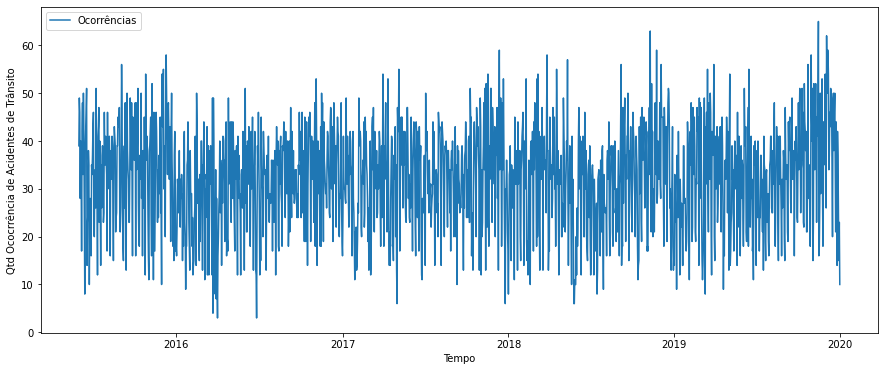

In [68]:
orig1 = plt.plot(full_df,label='Ocorrências')
plt.legend(loc='upper left')
plt.xlabel('Tempo')
plt.ylabel('Qtd Ococrrência de Acidentes de Trânsito')
plt.show()

### Para identificar se a série possui tendência e sazonalidade, é realizada a decomposição da mesma para uma melhor visualização dos dados. A decomposição da série permite separar os dados de tendência, sazonalidade e resíduo.

In [30]:
result = seasonal_decompose(full_df['count'], model='multiplicative')

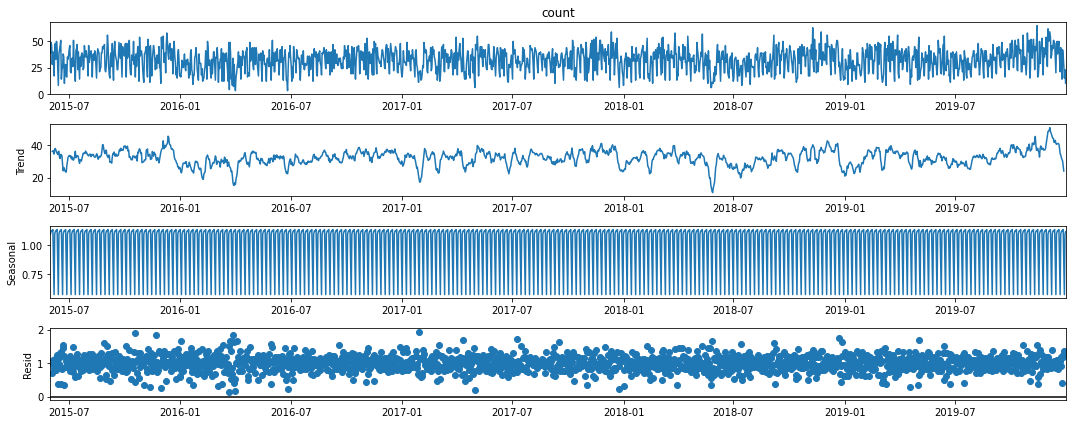

In [31]:
fig = result.plot()

##### Pode-se observar que a série possui uma sazonalidade com um periodo curto e com tendencia com valores oscilando sempre entre 40 e 20.

## 1. Existem Lags Relevantes?

Para avaliar a relevancia dos lags, é realizado o plot dos gráficos de autocorrelação e auto correlação parcial. Tais gráficos indicam a relação de um lag com seus antecessores.

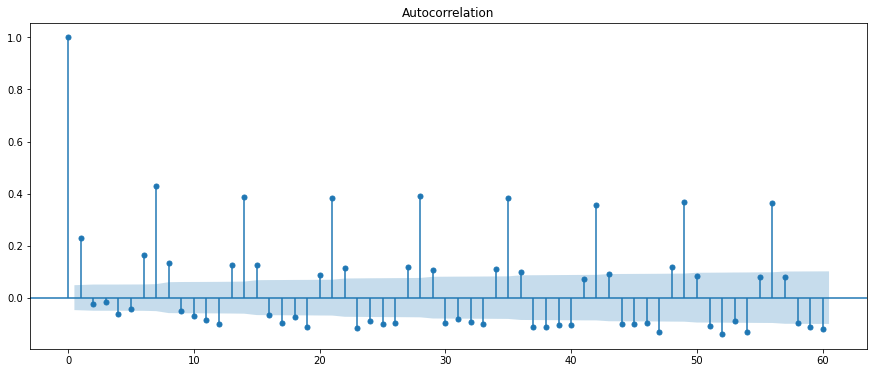

In [19]:
fig_acf = smt.graphics.plot_acf(full_df['count'], lags=60, alpha=0.05)

A partir deste gráfico é possivel identificar que a sazonalidade da série é de 7 dias devido ao intervalo de recorrência dos dados

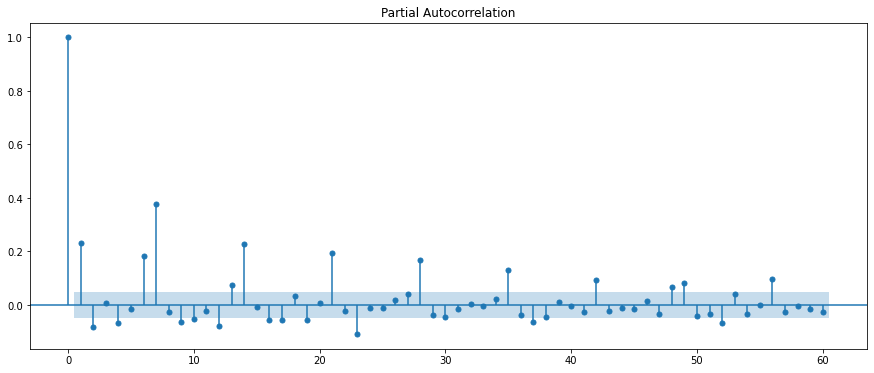

In [20]:
fig_pacf = smt.graphics.plot_pacf(full_df['count'], lags=60, alpha=0.05)

O gráfico de autocorrelação parcial indica a importancia dos lags. Pelo gráfico podemos observar que os lags: 1, 6, 7, 13, 14 e os demais multiplos de 7 até o lag 56 são significativos por estarem acima do intervalo de confiança.

## 2. A série é Estacionária?

Para realizar verificar a estacionariedade da série é recomendado utilizar o teste Kwiatkowski-Phillips-Schmidt-Shin de estacionariedade, e se o p-valor encontrado for menor do que o nivel de significancia de 5% a série é considerada estacionária.

In [21]:
serie = full_df['count'].values

In [55]:
kpss_test = kpss(serie,regression='ct', nlags='auto')

In [56]:
print('kpss = %f.' % kpss_test[0] ,'P-value = %f.' % kpss_test[1],'\n')

kpss = 0.169701. P-value = 0.030249. 



Como pode-se observar o p-valor encontrado foi de aproximadamente 0.03 e é menor do que os 5% sendo assim, podemos considerar a série estavcionária.

## 3. Quais outras estatísticas podem ajudar no entendimento da distribuição?

Para confirmar o resultado é recomendado realizar o teste de Dickey-Fuller Aumentado em combinação com o teste realizado anteriormente KPSS.

A hipótese nula do Dickey-Fuller Aumentado é que existe uma raiz unitária, com hipótese alternativa de que não existe uma raiz unitária. Se o valor de p estiver acima de um tamanho crítico, não podemos rejeitar a existência de uma raiz unitária.

In [63]:
adf = adfuller(serie, regression='ct', autolag="t-stat")
print('ADF = %f.' % adf[0] ,'P-value = %f.' % adf[1],'LAGS = %.i' % adf[2],'\n')

ADF = -6.663148. P-value = 0.000000. LAGS = 22 



In [60]:
adf

(-6.663148072010338,
 8.04762967810872e-08,
 22,
 1652,
 {'1%': -3.964260531107509,
  '5%': -3.4131509481595796,
  '10%': -3.1286165763368547},
 4.3552732652609825)

Como pode-se observar o teste também apresentou o p-valor menor do que 5% corroborando pela estacionariedade.

Outras análises possiveis são verificar a normalidade da série, e normalidade do resíduo para identificação se o mesmo é um ruído branco ou se possui padrões possíveis de serem extraídos.

In [ ]:
pmd